# Imports

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch
import torchmin
from scipy.interpolate import CubicSpline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [5]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
# spikes_file = filepath_root+'hotspots/spikes_combined_1H.csv'
# time_high_file = filepath_root+'hotspots/hotspots_combined_temporalhigh_1H.pkl'
# time_low_file = filepath_root+'hotspots/hotspots_combined_temporallow_1H.pkl'
# space_high_file = filepath_root+'hotspots/hotspots_combined_spatialhigh_1H.pkl'
# space_low_file = filepath_root+'hotspots/hotspots_combined_spatiallow_1H.pkl'

# Data Loading

In [6]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [7]:
df.replace(0, np.nan, inplace=True)

In [8]:
sensors = df.columns
duplicates = [1,13,34,9,24,50,51]
df[sensors[duplicates]]=np.nan

In [9]:
locs

,UDID,Latitude,Longitude,Address,Location,Type
Monitor ID,,,,,,
BB4A,492457f434f94afc865bb4701990bb4a,28.554980,77.194430,Jamun,Hauz Khas Village,Kaiterra
91B8,ea3ceeefd9654dfd9aab41422f7391b8,28.503050,77.185660,Vihara,Chhatapur,Kaiterra
BC46,29b8262425cf4135899cd65b2458bc46,28.632950,77.288700,Segel Design,Preet Vihar,Kaiterra
BFDC,11047d2ddc514f63a12ad4f1ad3bbfdc,28.521083,77.214237,Arundhati,Saket,Kaiterra
D804,f083e8afd43e4727a5eb7f3a1529d804,28.558230,77.208620,EPoD,Yusuf Sarai,Kaiterra
...,...,...,...,...,...,...
Sirifort_CPCB,NaN,28.550425,77.215938,NaN,"Sirifort, New Delhi - CPCB",Govt
SoniaVihar_DPCC,NaN,28.710508,77.249485,NaN,"Sonia Vihar, Delhi - DPCC",Govt
SriAurobindoMarg_DPCC,NaN,28.531346,77.190156,NaN,"Sri Aurobindo Marg, Delhi - DPCC",Govt


# Load Wind Speeds

In [10]:
df_ws = pd.read_csv('/scratch/ab9738/pollution_with_sensors/hotspots/source_apportionment/wind_speeds.csv', parse_dates=True)

df_ws = df_ws.sort_values(['Timestamp']).reset_index(drop=True)

df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['Timestamp']))

df_ws = df_ws[['u-component', 'v-component']].groupby('Timestamp').mean()

In [11]:
df_ws

,u-component,v-component
Timestamp,,
2018-05-01 00:00:00,-5.912000,3.205333
2018-05-01 06:00:00,-3.213333,5.312000
2018-05-01 12:00:00,-3.637333,-0.202667
2018-05-01 18:00:00,-6.544000,2.458667
2018-05-02 00:00:00,-4.949333,2.280000
...,...,...
2020-10-30 18:00:00,2.400000,-1.920000
2020-10-31 00:00:00,2.560000,-1.093333
2020-10-31 06:00:00,4.853333,-4.106667


# Load Intensity Maps

In [12]:
brick_kilns = np.load('brick_kilns_intensity_80x80.npy')
industries = np.load('industries_intensity_80x80.npy')
power_plants = np.load('power_plants_intensity_80x80.npy')
population_density = np.load('population_density_intensity_80x80.npy')
traffic_06 = np.load('traffic_06_intensity_80x80.npy')
traffic_12 = np.load('traffic_12_intensity_80x80.npy')
traffic_18 = np.load('traffic_18_intensity_80x80.npy')
traffic_00 = np.load('traffic_00_intensity_80x80.npy')

In [13]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

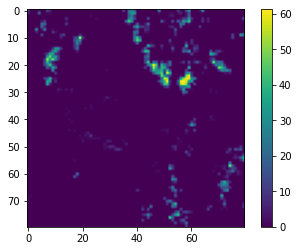

In [14]:
heatmap2d(brick_kilns)

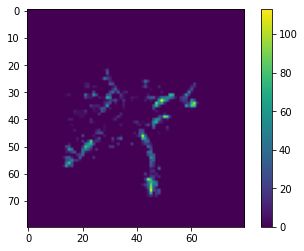

In [15]:
heatmap2d(industries)

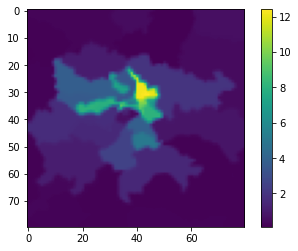

In [16]:
heatmap2d(population_density)

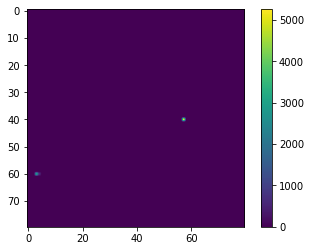

In [17]:
heatmap2d(power_plants)

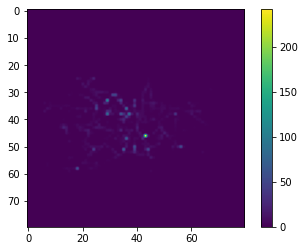

In [18]:
heatmap2d(traffic_12)

In [19]:
brick_kilns = torch.unsqueeze(torch.unsqueeze(torch.tensor(brick_kilns,dtype=torch.float),0),0).cuda()
industries = torch.unsqueeze(torch.unsqueeze(torch.tensor(industries,dtype=torch.float),0),0).cuda()
power_plants = torch.unsqueeze(torch.unsqueeze(torch.tensor(power_plants,dtype=torch.float),0),0).cuda()
population_density = torch.unsqueeze(torch.unsqueeze(torch.tensor(population_density,dtype=torch.float),0),0).cuda()
traffic_06 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_06,dtype=torch.float),0),0).cuda()
traffic_12 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_12,dtype=torch.float),0),0).cuda()
traffic_18 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_18,dtype=torch.float),0),0).cuda()
traffic_00 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_00,dtype=torch.float),0),0).cuda()

# Spline Values

In [20]:
sens = data.to_frame().reset_index()

sens['hour_of_day'] = sens['timestamp_round'].apply(lambda x: x.hour)

spline = sens.groupby(['field_egg_id', 'hour_of_day']).mean()['pm25'].reset_index()
spline_avg = sens.groupby(['hour_of_day']).mean()['pm25'].reset_index()

fields = []
times = []
pm25 = []
for i in np.unique(spline['field_egg_id']):
    s_i = spline[spline['field_egg_id']==i]
    x = s_i['hour_of_day'].values
    y = [t for t in s_i['pm25'].values]
    c1 = CubicSpline(x[:8],y[:8])
    c2 = CubicSpline(x[8:16],y[8:16])
    c3 = CubicSpline(x[16:24],y[16:24])
    ix = [k/100.0 for k in range(2400)]
    iy = list(np.concatenate((c1(ix[:800]),c2(ix[800:1600]),c3(ix[1600:2400]))))
    fields += [i]*2400
    times += ix
    pm25 += iy

spline_df = pd.DataFrame((fields, times, pm25)).transpose()

spline_df.columns = ['field_egg_id', 'time', 'pm25']

hours_in_day = np.arange(24).astype(float)

spline_df = spline_df[spline_df['time'].isin(hours_in_day)]

spline_mat = np.transpose(spline_df['pm25'].to_numpy().reshape((60,24))).astype(float)

spline_tensor = torch.tensor(spline_mat).cuda()

# Gaussian-Plume Model for Point Source

## Core Gaussian-Plume Dispersion Formula

In [21]:
# def gaussian_plume(src, dest, intensity, wind_speed, alpha, H, z=6.5, a=213, c=459.7, d=2.094, offset=100):
#     # import pdb; pdb.set_trace()
#     if(intensity>0):
#         wind_speed[1] = -wind_speed[1]
#         unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         if(src!=dest):
#             unit_distance_vector = np.array([dest[1]-src[1], dest[0]-src[0]])/math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2)) 
#             #reversing as lat=y-axis and long=x-axis
#             distance = math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2))*math.pow(10,5)
#             distance_vector = distance * unit_distance_vector
#             x = np.dot(distance_vector, unit_wind_vector)
#             if(x<=0):
#                 return(0.0)
#             else:
#                 x = min(x,distance)
#                 y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
#                 x = max(x,offset)
#         else:
#             x = offset
#             y = 0
#         sigma_z = c*math.pow(x*0.001,d)
#         sigma_z = min(5000,sigma_z)
#         sigma_y = a*math.pow(x*0.001,0.894)
#         concentration = ((alpha*intensity)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
#         (math.exp(-(math.pow(z-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(z+H,2)/math.pow(2*sigma_z,2))))
#         return(concentration)
#     else:
#         return 0

## Computing concentration at a sensor because of different sources

In [22]:
# def compute_concentration(dest, ts, wind_speed, unknown, alpha, H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400,\
#                                                                        'unknown':0}):
    
#     # Find the correct timestamp for the traffic sources
#     if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
#         traffic_srcs = traffic_06
#     elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
#         traffic_srcs = traffic_12
#     elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
#         traffic_srcs = traffic_18
#     else:
#         traffic_srcs = traffic_00
    
    
#     # Initialize the different source contributions
#     contrib_brick, contrib_industry, contrib_population, contrib_traffic, contrib_power, contrib_unknown = 0.0,0.0,0.0,0.0,0.0,0.0
    
#     # Define the grid of sources under consideration
#     idx_x = int((dest[1]-76.85)/0.01)
#     idx_y = 79-int((dest[0]-28.2)/0.01)
#     src_radius = 7
        
#     for i in range(max(idx_y-src_radius,0), min(idx_y+src_radius+1,79)):
#         for j in range(max(idx_x-src_radius,0), min(idx_x+src_radius+1,79)):
#             src = (28.2+((79-j)*0.01)+0.005, 76.85+(i*0.01)+0.005)
#             contrib_brick += gaussian_plume(src, dest, brick_kilns[i,j], wind_speed, alpha['brick_kilns'], H['brick_kilns'])
#             contrib_industry += gaussian_plume(src, dest, industries[i,j], wind_speed, alpha['industry'], H['industry'])
#             contrib_population += gaussian_plume(src, dest, population_density[i,j], wind_speed, alpha['population'], H['population'])
#             contrib_traffic += gaussian_plume(src, dest, traffic_srcs[i,j], wind_speed, alpha['traffic'], H['traffic'])
#             contrib_power += gaussian_plume(src, dest, power_plants[i,j], wind_speed, alpha['power'], H['power'])
#             contrib_unknown += gaussian_plume(src, dest, unknown[i,j], wind_speed, alpha['unknown'], H['unknown'])
            
#     total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic + contrib_power + contrib_unknown
#     contrib = [contrib_brick, contrib_industry, contrib_population, contrib_traffic, contrib_unknown]
#     return total_concentration

# Gaussian Plume Filter

In [23]:
def gpdm_filter(H, wind_speed, size):
    filt = torch.zeros((size,size)).cuda()
    dest_x, dest_y = int(size/2), int(size/2)
    wind_speed[1] = -wind_speed[1]
    for i in range(size):
        for j in range(size):
            src_x, src_y = i, j
            unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
            wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
            if(dest_x!=src_x and dest_y!=src_y):
                unit_distance_vector = np.array([dest_x-src_x, dest_y-src_y])/math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))
                distance = math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))*math.pow(10,5)
                distance_vector = distance * unit_distance_vector
                x = np.dot(distance_vector, unit_wind_vector)
                if(x<=0):
                    continue
                else:
                    if(math.pow(distance,2)-math.pow(x,2)<0):
                        x = distance
                    y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
                    x = max(x,250)
            else:
                x = 250
                y = 0
            sigma_z = 459.7*math.pow(x*0.001,2.094)
            sigma_z = min(5000,sigma_z)
            sigma_y = 213*math.pow(x*0.001,0.894)
            filt[i,j] = (math.pow(10,9)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
        (math.exp(-(math.pow(6.5-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(6.5+H,2)/math.pow(2*sigma_z,2))))
    return(torch.unsqueeze(filt,0))

In [24]:
def compute_filters(ts_array, H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400}):
    
    ts_filters = {'traffic':[], 'brick_kilns':[], 'population':[], 'industry':[], 'power':[]}
    src_radius = 7
    
    for ts in ts_array:
        wind_speed = get_wind_speed_estimate(ts)
        ts_filters['brick_kilns'].append(gpdm_filter(H['brick_kilns'], wind_speed, 2*src_radius+1))
        ts_filters['industry'].append(gpdm_filter(H['industry'], wind_speed, 2*src_radius+1))
        ts_filters['population'].append(gpdm_filter(H['population'], wind_speed, 2*src_radius+1))
        ts_filters['traffic'].append(gpdm_filter(H['traffic'], wind_speed, 2*src_radius+1))
        ts_filters['power'].append(gpdm_filter(H['power'], wind_speed, 2*src_radius+1))
    for srcs in list(ts_filters.keys()):
        ts_filters[srcs] = torch.stack(ts_filters[srcs]) 
    return(ts_filters)

In [26]:
def convolve_at_sensors(sensors, ts_array, alpha, unknown, ts_filter):    
    
    concentrations_at_sensors = []
    src_radius = 7
    
    for sensor in sensors:
        dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
        idx_x = int((dest[1]-76.85)/0.01)
        idx_y = 79-int((dest[0]-28.2)/0.01)
        
        contrib_brick = torch.nn.functional.conv2d(ts_filter['brick_kilns'], \
                                                   brick_kilns[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_industry = torch.nn.functional.conv2d(ts_filter['industry'], \
                                                   industries[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_population = torch.nn.functional.conv2d(ts_filter['population'], \
                                                   population_density[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_06 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_06[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_00 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_00[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_12 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_12[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_18 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_18[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_power = torch.nn.functional.conv2d(ts_filter['power'], \
                                                   power_plants[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_unknown = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   unknown[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic = torch.zeros_like(contrib_traffic_06)
        for i in range(len(ts_array)):
            ts = ts_array[i]
            if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
                contrib_traffic[i] = contrib_traffic_06[i]
            elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
                contrib_traffic[i] = contrib_traffic_12[i]
            elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
                contrib_traffic[i] = contrib_traffic_18[i]
            else:
                contrib_traffic[i] = contrib_traffic_00[i]
            
        total_concentration = alpha['brick_kilns']*contrib_brick + alpha['industry']*contrib_industry + \
        alpha['traffic']*contrib_traffic + alpha['unknown']*contrib_unknown + alpha['power']*contrib_power \
        # + alpha['population']*contrib_population
        # total_concentration = alpha['unknown']*contrib_unknown
        total_concentration = torch.squeeze(total_concentration)
        concentrations_at_sensors.append(total_concentration)
    return(concentrations_at_sensors)

## Find nearest wind speed data

In [27]:
def get_wind_speed_estimate(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    if(pd.Timestamp(ts).hour in [5,11,17,23]):
        ts = ts+np.timedelta64(30,'m')
    else:
        ts = ts-np.timedelta64(30,'m')

    ws = df_ws.loc[ts].values
    ws = ws*(5.0/18)
    return(ws)

## Filtering data points based on time so that wind data is only 30 minutes in deviation.

In [28]:
def check_timestamp(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    if(pd.Timestamp(ts).hour in [5,11,17,23]):
        ts = ts+np.timedelta64(30,'m')
    else:
        ts = ts-np.timedelta64(30,'m')

    try:
        ws = df_ws.loc[ts].values
        return(True)
    except:
        return(False)

ws_timestamps = df_ws.index.to_numpy()
ts_array = np.array(list(set(data.dropna().index.get_level_values("timestamp_round").to_numpy())))
ts_array = np.sort(ts_array)
df_timestamps = pd.DataFrame(ts_array)
ts_array = ts_array[df_timestamps[0].apply(lambda x: True if x.hour in [5,6,11,12,17,18,23,0] else False).to_numpy().astype(np.bool)]
df_timestamps = pd.DataFrame(ts_array)
ts_array = ts_array[df_timestamps[0].apply(check_timestamp).to_numpy().astype(np.bool)]

In [29]:
np.random.shuffle(ts_array)
train, test = ts_array[:int(0.8*len(ts_array))], ts_array[int(0.8*len(ts_array)):]
train_subset = random.sample(list(train), 1)

# Unkown Source Optimization 

In [30]:
train_filters = compute_filters(train)

In [31]:
def get_mse(params):
    alpha = params['alpha']
    unknown = params['unknown']
    sensors = df.columns
    comp_values = torch.stack(convolve_at_sensors(sensors, train, alpha, unknown, train_filters),1)
    mes_values = torch.tensor(df.loc[train].to_numpy(),dtype=torch.float).cuda()
    spline_values = torch.zeros_like(comp_values)
    for i in range(len(train)):
        idx = int(train[i].hour)
        spline_values[i] = spline_tensor[idx]    
    # comp_values = comp_values + spline_values
    mask = mes_values.isnan().long()
    comp_values = comp_values*mask
    mes_values = torch.nan_to_num(mes_values)
    mse = torch.nn.functional.mse_loss(mes_values,comp_values)
    return(mse)

def opt_fn(inp_vec):
    unknown_arr = inp_vec[:6400]
    alpha_arr = torch.abs(inp_vec[6400:])
    alpha = {'traffic':alpha_arr[0]*math.pow(10,-7), 'brick_kilns':alpha_arr[1]*math.pow(10,-7), 'population':alpha_arr[2]*math.pow(10,-7),\
             'industry':alpha_arr[3]*math.pow(10,-7), 'power':alpha_arr[4]*math.pow(10,-7), 'unknown':alpha_arr[5]*math.pow(10,-7)}
    unknown = torch.reshape(unknown_arr,(80,80))
    # unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
    unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
    # unknown = torch.abs(population_density+unknown)
    unknown = torch.abs(unknown)
    scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
    # scale = 5000
    unknown = unknown*scale
    params = {'alpha':alpha, 'unknown':unknown}
    
    mse = get_mse(params)
    return(mse)

In [32]:
init_vector = torch.rand(6406, requires_grad=True, device='cuda')
opt = torch.optim.RMSprop([init_vector], lr=1e-1)

In [33]:
for e in range(1000):
    loss = opt_fn(init_vector)
    print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step() 

tensor(11261.3320, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11222.7734, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.6973, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4316, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4131, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4131, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4131, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11211.4121, device='cuda:0', grad

KeyboardInterrupt: 

In [34]:
# init_vector = torch.rand(6406,device='cuda')
# Nfeval = 1
# def callbackF(Xi):
#     global Nfeval
#     print(Nfeval)
#     print(opt_fn(Xi))
#     Nfeval += 1
# res = torchmin.minimize(opt_fn, init_guess, method='newton-cg', disp=1, max_iter=1000, callback=callbackF, options={'xtol':0,'lr':100.0})

In [35]:
init_vector

tensor([ 6.5882e-01,  3.9927e-01,  4.4090e-01,  ...,  1.0128e-08,
        -3.6139e-02,  9.4179e-09], device='cuda:0', requires_grad=True)

# Evaluation of Gaussian Plume Model

In [36]:
test_filters = compute_filters(test)

In [37]:
def evaluate(inp_vec):
    unknown_arr = inp_vec[:6400]
    alpha_arr = torch.abs(inp_vec[6400:])
    alpha = {'traffic':alpha_arr[0]*math.pow(10,-7), 'brick_kilns':alpha_arr[1]*math.pow(10,-7), 'population':alpha_arr[2]*math.pow(10,-7),\
             'industry':alpha_arr[3]*math.pow(10,-7), 'power':alpha_arr[4]*math.pow(10,-7), 'unknown':alpha_arr[5]*math.pow(10,-7)}
    unknown = torch.reshape(unknown_arr,(80,80))
    unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
    # unknown = torch.abs(population_density+unknown)
    unknown = torch.abs(unknown)
    scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
    unknown = unknown*scale
    
    sensors = df.columns
    comp_values = torch.stack(convolve_at_sensors(sensors, test, alpha, unknown, test_filters),1)
    mes_values = torch.tensor(df.loc[test].to_numpy(),dtype=torch.float).cuda()
    mask = mes_values.isnan().long()
    comp_values = comp_values*mask
    mes_values = torch.nan_to_num(mes_values)
    
    mse = torch.nn.functional.mse_loss(mes_values,comp_values)
    abs_err = torch.abs(mes_values-comp_values)
    percent_abs_err = torch.div(abs_err,mes_values)*100
    percent_abs_err = torch.nan_to_num(percent_abs_err, posinf=0)
    mape = torch.mean(percent_abs_err)
    return(mse, mape)

In [38]:
rmse, mape = evaluate(init_vector)

In [39]:
print(rmse, mape)

tensor(11185.0830, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(59.5082, device='cuda:0', grad_fn=<MeanBackward0>)


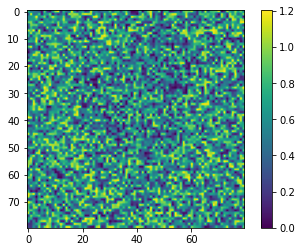

In [40]:
unknown_arr = init_vector[:6400]
unknown = torch.reshape(unknown_arr,(80,80))
# unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
# unknown = torch.abs(population_density+unknown)
unknown = torch.abs(unknown)
scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
# scale = 5000
unknown = unknown*scale
unknown = torch.squeeze(unknown)
unknown = unknown.cpu().detach().numpy()
heatmap2d(unknown)

# Mapping and Source Apportionment of Hotspots

In [41]:
def full_convolutions_at_ts(idx, alpha, unknown, ts_filter):

    contrib_brick = torch.nn.functional.conv2d(brick_kilns, torch.unsqueeze(ts_filter['brick_kilns'][idx],0), padding='same')
    contrib_industry = torch.nn.functional.conv2d(industries, torch.unsqueeze(ts_filter['industry'][idx],0), padding='same')
    contrib_population = torch.nn.functional.conv2d(population_density, torch.unsqueeze(ts_filter['population'][idx],0), padding='same')
    contrib_traffic_06 = torch.nn.functional.conv2d(traffic_06, torch.unsqueeze(ts_filter['traffic'][idx],0), padding='same')
    contrib_traffic_00 = torch.nn.functional.conv2d(traffic_00, torch.unsqueeze(ts_filter['traffic'][idx],0), padding='same')
    contrib_traffic_12 = torch.nn.functional.conv2d(traffic_12, torch.unsqueeze(ts_filter['traffic'][idx],0), padding='same')
    contrib_traffic_18 = torch.nn.functional.conv2d(traffic_18, torch.unsqueeze(ts_filter['traffic'][idx],0), padding='same')
    contrib_power = torch.nn.functional.conv2d(power_plants, torch.unsqueeze(ts_filter['power'][idx],0), padding='same')
    contrib_unknown = torch.nn.functional.conv2d(unknown, torch.unsqueeze(ts_filter['traffic'][idx],0), padding='same')
    contrib_traffic = torch.zeros_like(contrib_traffic_06)
    ts = ts_array[idx]
    if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
        contrib_traffic = contrib_traffic_06
    elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
        contrib_traffic = contrib_traffic_12
    elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
        contrib_traffic = contrib_traffic_18
    else:
        contrib_traffic = contrib_traffic_00

    total_concentration = alpha['brick_kilns']*contrib_brick + alpha['industry']*contrib_industry + \
    alpha['population']*contrib_population + alpha['traffic']*contrib_traffic + alpha['unknown']*contrib_unknown + alpha['power']*contrib_power
    return(total_concentration)

In [42]:
unknown_arr = init_vector[:6400]
alpha_arr = torch.abs(init_vector[6400:])
alpha = {'traffic':alpha_arr[0]*math.pow(10,-7), 'brick_kilns':alpha_arr[1]*math.pow(10,-7), 'population':alpha_arr[2]*math.pow(10,-7),\
         'industry':alpha_arr[3]*math.pow(10,-7), 'power':alpha_arr[4]*math.pow(10,-7), 'unknown':alpha_arr[5]*math.pow(10,-7)}
unknown = torch.reshape(unknown_arr,(80,80))
# unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
# unknown = torch.abs(population_density+unknown)
unknown = torch.abs(unknown)
scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
# scale = 5000
unknown = unknown*scale
map_array = full_convolutions_at_ts(100,alpha,unknown,train_filters)

In [43]:
map_array = torch.squeeze(map_array).cpu().detach().numpy()

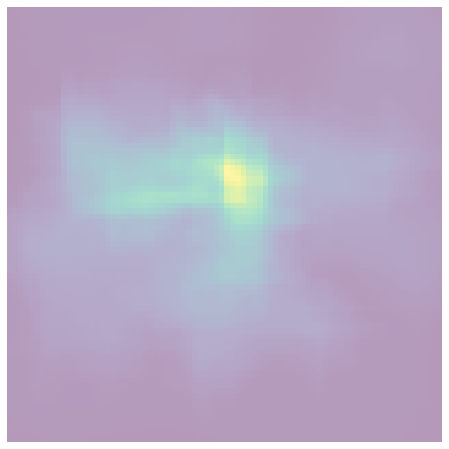

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(map_array, cmap='viridis', interpolation='nearest', alpha=0.4)
plt.axis('off')
# plt.colorbar()
# plt.show()
plt.savefig('heatmap.png',bbox_inches='tight')

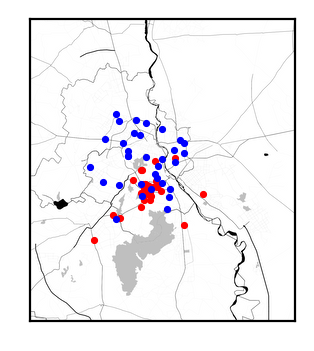

In [45]:
# region_lat_b, region_lat_t, region_long_l, region_long_r = 28.39, 28.78, 77.01, 77.40
region_lat_b, region_lat_t, region_long_l, region_long_r = 28.20, 29.00, 76.85, 77.65
subset_locs = locs[(locs['Latitude']<region_lat_t) & (locs['Latitude']>region_lat_b) &\
                   (locs['Longitude']<region_long_r) & (locs['Longitude']>region_long_l)]

lat_lims = region_lat_b, region_lat_t
lon_lims = region_long_l, region_long_r
lat_center, lon_center = (region_lat_b + region_lat_t)/2, (region_long_l + region_long_r)/2

extent = tilemapbase.Extent.from_lonlat(region_long_l, region_long_r, region_lat_b, region_lat_t)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(2,2), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.margins(x=0)
plt.margins(y=0)
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in subset_locs.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=10, label='Our sensors')
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b', s=10, label='CPCB/DPCC/IMD')
    # ax.text(x, y, row.Index, fontsize=3)

# ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)
plt.savefig('hsp_map.png',bbox_inches='tight')
plt.show()

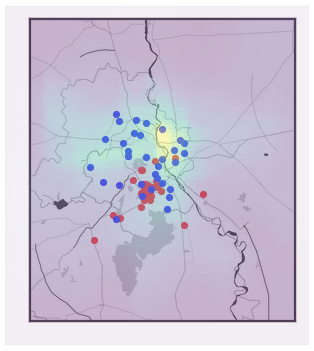

In [46]:
hsp_map = Image.open('./hsp_map.png')
heatmap = Image.open('./heatmap.png')

heatmap = heatmap.resize(hsp_map.size)

hsp_map.paste(heatmap,(0,0),heatmap)

hsp_map